# Restauración de información en mapas bidimensionales obtenidos en experimentos por dispersión de rayos X.

# Parte I

Autor: Gustavo Quintero

28 de Mayo 2021



## 1. Resumen

El presente notebook corresponde al trabajo final realizado para obtener el título de Especialista en Aplicaciones Tecnológicas de la Energía Nuclear, un Posgrado dictado por el Instituto Balseiro (IB) y la Universidad de Buenos Aires (UBA). En este trabajo se aplican dos métodos de restauración de imágenes en mapas de transmisión, absorción y dispersión obtenidos a través SAXS (una técnica de caracterización de materiles). Permitiendo mejorar significativamente la calidad de los mapas obtenidos y extraer información estructural de la muestra en estudio con una mejor precisión y un mayor peso estadístico.

## 2. Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fabio
import re
import os
import cv2
import matplotlib.colors

from celluloid import Camera
from matplotlib.ticker import LogFormatter
from matplotlib import ticker, cm
from tifffile import imread, imsave
from scipy.signal import fftconvolve
from pandas import Series, DataFrame
from numpy import nan as NA
from mpl_toolkits.mplot3d import Axes3D
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.restoration import richardson_lucy, unsupervised_wiener

## 3. Funciones

In [2]:
def scalematrix(m, scale):
  # Crear matriz con ceros del tamaño apropiado
  r = np.zeros(((m.shape[0]-1)*scale+1, (m.shape[1]-1)*scale+1))

  # Rellenar filas multiplo de scale (interpolando entre valores de los elementos de la fila)
  for fil in range(m.shape[0]):
    for col in range(m.shape[1]-1):
      r[fil*scale, col*scale:(col+1)*scale+1] = np.linspace(m[fil,col], m[fil,col+1], scale+1)

  # Rellenar resto de ceros, interpolando entre elementos de las columnas
  for fil in range(m.shape[0]-1):
    for col in range(r.shape[1]):
      r[fil*scale:(fil+1)*scale + 1, col] = np.linspace(r[fil*scale,col], r[(fil+1)*scale, col], scale+1)
  return r

def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

## 4. Datos

Los datos con los que se trabajan corresponden con la medición de un mapa (imagen) de transmisión de rayos X de una semilla de chía.

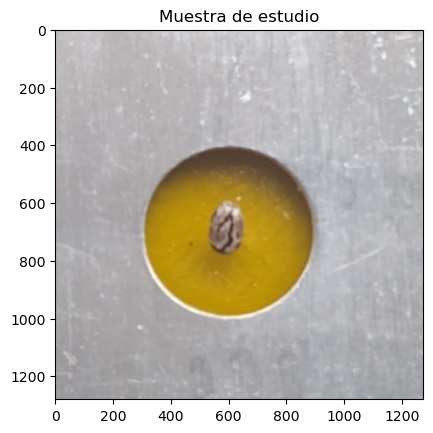

In [3]:
Chia = imread('Chia.tif')
plt.imshow(Chia)
plt.title('Muestra de estudio')
plt.show()

Se abre el archivo que se obtuvo de la medición y se extraen los datos con los que se van a trabajar

In [4]:
with open('20210415_saxs1_a1.txt','r') as file:
    data = file.read()
pattern = '(?<=\#L)[^#L]*(?=#S)'
data = re.findall(pattern,data)

Se ordenan los datos en un diccionario para poder manipularlos de una mejor manera haciendo uso de un DataFrame

In [5]:
table={}
for i in range(0,len(data)):
    s = data[i]
    s = [text.strip() for text in s.splitlines()]
    s = [text.split() for text in s]
    s[0]= list(pd.unique(s[0]))
    s[0].pop(5)
    s.pop(len(s)-1)
    data1 = {}
    for j in range(0,len(s[0])):
        data1[s[0][j]]=[]
        for k in range(1,len(s)):
            data1[s[0][j]].append(float(s[k][j]))
    table[str(i+1)]= data1
data = pd.DataFrame(table)
data

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
X,"[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...",...,"[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599...","[-2.2975713, -2.2475903, -2.1975801, -2.147599..."
Epoch,"[36.533, 38.532, 40.541, 42.542, 44.6, 46.632,...","[164.421, 166.452, 168.536, 170.529, 172.564, ...","[292.364, 294.341, 296.325, 298.261, 300.249, ...","[420.506, 422.457, 424.357, 426.308, 428.325, ...","[548.177, 550.2, 552.208, 554.288, 556.376, 55...","[676.189, 678.148, 680.127, 682.209, 684.148, ...","[803.928, 805.928, 807.976, 809.988, 811.964, ...","[932.188, 934.149, 936.115, 938.092, 940.069, ...","[1060.496, 1062.445, 1064.365, 1066.273, 1068....","[1188.24, 1190.249, 1192.368, 1194.372, 1196.3...",...,"[6433.293, 6435.185, 6437.128, 6439.196, 6441....","[6560.732, 6562.717, 6564.781, 6566.732, 6568....","[6688.521, 6690.444, 6692.472, 6694.452, 6696....","[6816.585, 6818.501, 6820.584, 6822.536, 6824....","[6945.388, 6947.384, 6949.365, 6951.389, 6953....","[7073.476, 7075.428, 7077.392, 7079.345, 7081....","[7201.406, 7203.365, 7205.377, 7207.353, 7209....","[7330.423, 7332.337, 7334.328, 7336.357, 7338....","[7458.684, 7460.712, 7462.636, 7464.677, 7466....","[7586.312, 7588.341, 7590.273, 7592.301, 7594...."
Seconds,"[0.504, 0.503, 0.506, 0.503, 0.504, 0.504, 0.5...","[0.505, 0.504, 0.503, 0.501, 0.505, 0.504, 0.5...","[0.504, 0.504, 0.509, 0.506, 0.503, 0.504, 0.5...","[0.504, 0.505, 0.504, 0.503, 0.503, 0.504, 0.5...","[0.504, 0.503, 0.503, 0.504, 0.504, 0.503, 0.5...","[0.505, 0.503, 0.503, 0.504, 0.506, 0.503, 0.5...","[0.505, 0.504, 0.504, 0.502, 0.506, 0.504, 0.5...","[0.504, 0.506, 0.504, 0.504, 0.503, 0.507, 0.5...","[0.504, 0.503, 0.508, 0.507, 0.505, 0.504, 0.5...","[0.504, 0.505, 0.503, 0.504, 0.504, 0.503, 0.5...",...,"[0.504, 0.504, 0.504, 0.504, 0.508, 0.505, 0.5...","[0.503, 0.506, 0.503, 0.503, 0.503, 0.503, 0.5...","[0.504, 0.504, 0.506, 0.503, 0.503, 0.504, 0.5...","[0.504, 0.503, 0.504, 0.504, 0.504, 0.505, 0.5...","[0.504, 0.505, 0.504, 0.503, 0.503, 0.503, 0.5...","[0.504, 0.504, 0.504, 0.505, 0.504, 0.504, 0.5...","[0.504, 0.503, 0.507, 0.503, 0.505, 0.505, 0.5...","[0.504, 0.505, 0.505, 0.501, 0.505, 0.506, 0.5...","[0.504, 0.504, 0.504, 0.503, 0.507, 0.506, 0.5...","[0.503, 0.507, 0.504, 0.504, 0.505, 0.504, 0.5..."
Detector,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0

Una vez ordenados, se procede a extraer los valores de intensidades transmitidas (fila 'Roi0'), para poder visualizar el mapa (imagen) de transmisión medido. 

In [6]:
color = 'magma'

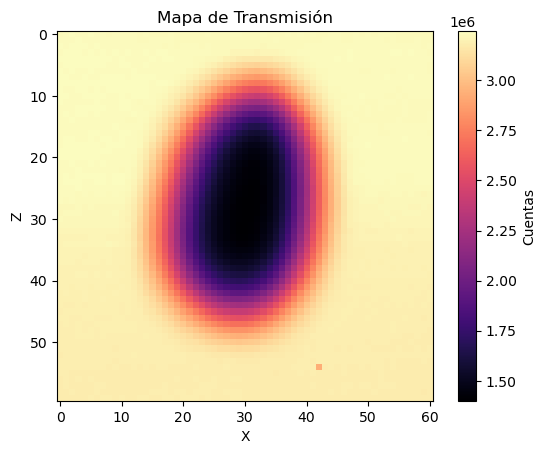

In [7]:
a = data.iloc[-1]
I = [a[i] for i in range(0,len(a))]
I = np.array(I)
plt.imshow(I, cmap =color)
plt.title('Mapa de Transmisión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

Luego, se divide cada pixel del mapa de transmisión con el valor de tiempo asociado (fila 'Seconds' del DataFrame) para disminuir el error de cuentas en el detector que presentan los datos. 

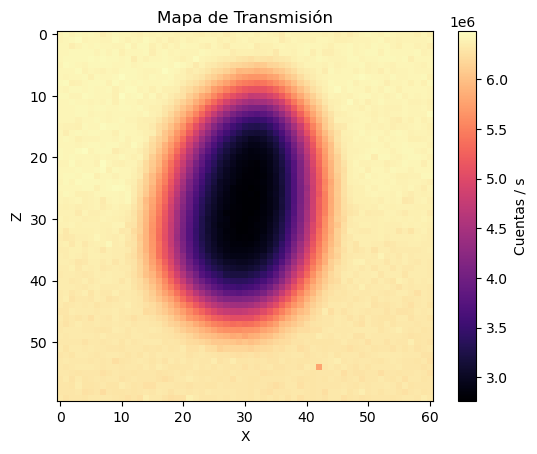

In [8]:
b = data.iloc[2]
T = [b[i] for i in range(0,len(b))]
T = np.array(T)
G = I/T
plt.imshow(G, cmap=color)
plt.title('Mapa de Transmisión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas / s")
plt.show()

Ahora, se extraen los datos correspondiente a la medición de la intensidad del haz de fotones que incide sobre la muestra.

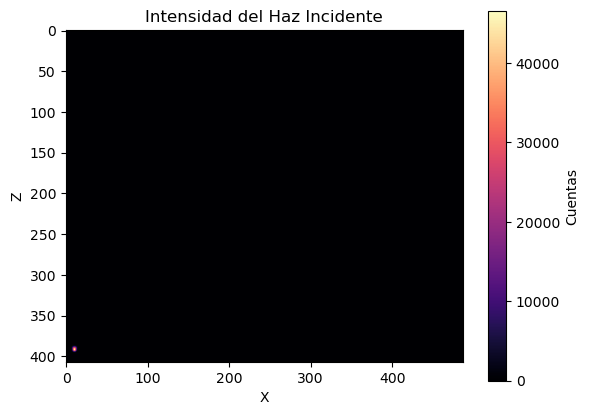

In [9]:
haz = fabio.open("Nahir_Vadra_20210413_0_00001.edf")
h = haz.data
plt.imshow(h, cmap=color)
plt.title('Intensidad del Haz Incidente')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

Se selecciona la región de interes ubicada en la parte inferior izquierda de la imagen

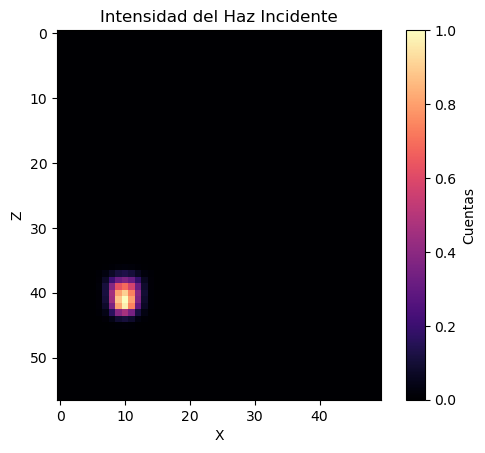

In [10]:
h1= h[350:,0:50]
h1 = h1/(np.amax(h1)) #normalización de la intensidad del haz
plt.imshow(h1, cmap=color)
plt.title('Intensidad del Haz Incidente')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

De estos valores se toman aquellos mayores al 1% de la intensidad maxima

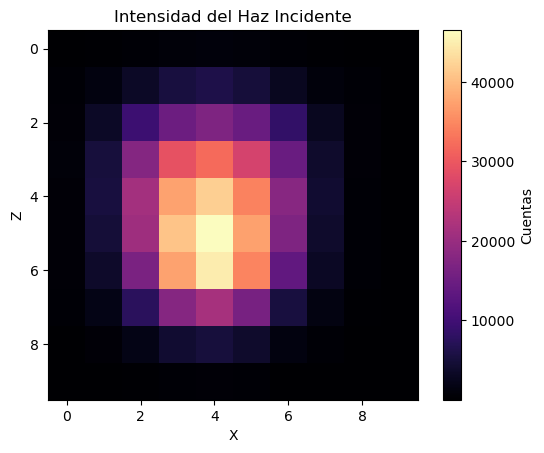

In [11]:
h1 = np.where(h1 > 0.01, h1, 0)
(i,j) = h1.shape
for m in range(i-1,-1,-1):
    for n in range(0,j):
        if h1[m,n] != 0:
            b = m
            break
for m in range(0,i):
    for n in range(0,j):
        if h1[m,n] != 0:
            c = m
            break
fl = (b,c)
for n in range(j-1,-1,-1):
    for m in range(0,i):
        if h1[m,n] != 0:
            d = n
            break
for n in range(0,j):
    for m in range(0,i):
        if h1[m,n] != 0:
            e = n
            break
cl = (d,e)
h1= h[350:,0:50]
#h1 = h1/(np.amax(h1))
h2 = h1[b:c+1,d:e+2]
#h2 = h2*np.amax(h1)
plt.imshow(h2, cmap = color)
plt.title('Intensidad del Haz Incidente')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas")
plt.show()

En 3D, se obtiene

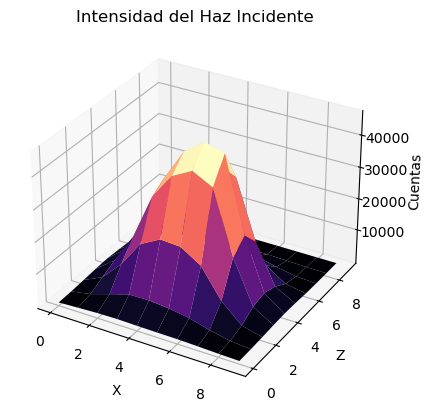

In [12]:
meshgrid = pd.DataFrame(h2)
x1 = np.linspace(1, 10, 10).astype(int)
x1 = x1-1
y1 = np.linspace(1, 10, 10).astype(int)
y1 = y1-1
X1, Y1 = np.meshgrid(x1, y1)
z1 = np.array([h2[i,j] for i,j in zip(np.ravel(X1), np.ravel(Y1))])
Z1 = z1.reshape(X1.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, Y1, Z1, cmap=color, edgecolor='none')
ax.set_title('Intensidad del Haz Incidente')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Cuentas')
plt.show()

Cada píxel en el mapa de intensidad del haz incidente tiene dimensiones de $0.172𝑚𝑚$, mientras que cada píxel en el mapa de transmisión de la muestra mide $0.05𝑚𝑚$. Para llevar acabo la restauración,  es necesario redimensionar el mapa del haz utilizando un factor de escala de $0.172/0.05=3.44≈3$. Este ajuste se realiza a través de un proceso de interpolación.

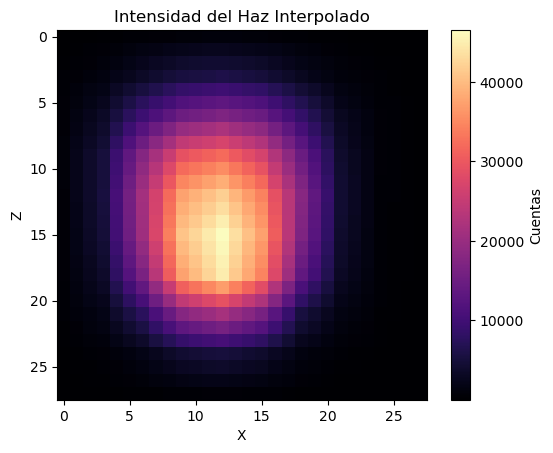

In [13]:
h3 = scalematrix(h2, scale=3)
plt.imshow(h3, cmap =color)
plt.title('Intensidad del Haz Interpolado')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas")
plt.show()

En 3D, se obtiene

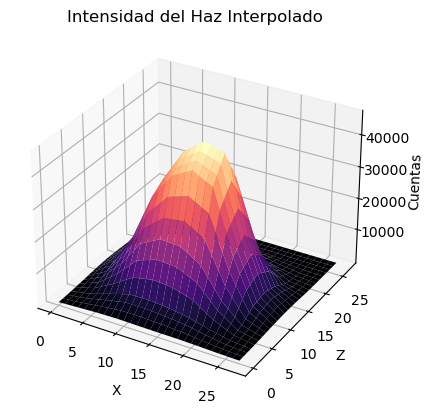

In [14]:
(k,l)=h3.shape
x2 = np.linspace(1, k, l).astype(int)
x2 = x2-1
y2 = np.linspace(1, k, l).astype(int)
y2 = y2-1
X2, Y2 = np.meshgrid(x2, y2)
z2 = np.array([h3[i,j] for i,j in zip(np.ravel(X2), np.ravel(Y2))])
Z2 = z2.reshape(X2.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X2, Y2, Z2,rstride=1, cstride=1, cmap=color, edgecolor='none')
ax.set_title('Intensidad del Haz Interpolado')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Cuentas')
plt.show()


Una vez interpolado el mapa de intensidad del haz, se procede a generar un nuevo mapa con dimensiones de $0.5𝑚𝑚×0.5𝑚𝑚$, que representan la apertura física mínima del haz. Considerando que cada grupo de 3 píxeles equivale a una dimensión de $0.172𝑚𝑚$, se determina que se deben tomar $0.5𝑚𝑚/0.172𝑚𝑚=2.9≈3$ píxeles del mapa. Por lo tanto, el nuevo mapa debe estar constituido por $9×9 píxeles$. De esta manera,

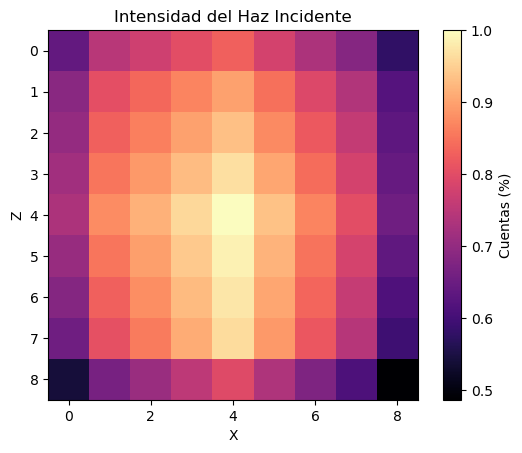

In [15]:
i,j = np.where(h3 == np.amax(h3))
h4=h3[i[0]-4:i[0]+5,j[0]-4:j[0]+5]
h4=h4/np.amax(h3)
plt.imshow(h4, cmap =color)
plt.title('Intensidad del Haz Incidente')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas (%)")
plt.show()

## 5. Procesamiento de Datos

A partir del mapa de transmisión, es posible obtener un mapa relacionado con el coeficiente de absorción de la muestra, mediante la aplicación de una transformación específica. Esto se logra utilizando la siguiente ecuación

$$I_f=I_0\exp(-\mu x)\longrightarrow \ln(I_0/I_f)=\mu x\hspace{1cm}(I)$$

Donde

- $I_0$ es la intensidad de haz de fotones incidente sobre la muestra.
- $I_f$ es la intensidad del haz de fotones transmitido por la muestra.
- $\mu$ es el coeficiente de absorción de la muestra.
- $x$ es el espesor de la muestra.

La ecuación $(I)$ establece que al conocer el valor de $I_0$, es posible obtener un mapa relacionado con el coeficiente de absorción y el espesor de la muestra a partir de $I_f$ (el mapa de transmisión medido). Por consiguiente, es esencial determinar el valor de $I_0$. Para llevar a cabo esta tarea, se emplearan dos métodos

- En el primero, se toma el valor de $I_0$ de un promedio de 100 valores extraidos del mapa de transmisión, en una matriz 10×10 tomada de la parte superior izquierda del mapa (zona amarilla).

- En el segundo, se realiza la segmentación de la zona asociada a la semilla de chia y luego de la extración de esta región se realiza un promediado con los valores restantes.

**Método 1**

In [16]:
C = G[0:10,0:10]
mean1 = np.mean(C)

**Método 2**

In [17]:
q = G
ig = inverse_gaussian_gradient(G)
init_ls = np.zeros(ig.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
evolution = []
callback = store_evolution_in(evolution)
seg = morphological_geodesic_active_contour(ig, 230, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback)

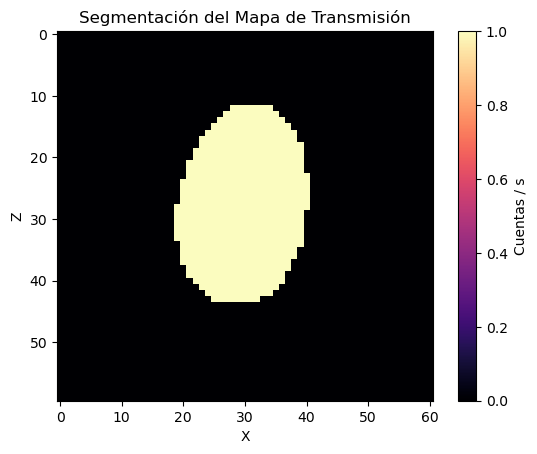

In [18]:
plt.imshow(seg, cmap = color)
plt.title('Segmentación del Mapa de Transmisión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas / s")
plt.show()

In [19]:
(i,j) = seg.shape
f = []
for k in range(i):
    for l in range(j):
        if seg[k,l] == 1:
            f.append((k,l))

for i in range(len(f)):
    q[f[i]] = NA

In [20]:
o = pd.DataFrame(q)
o = o.dropna()
o = np.array(o)
mean2=np.mean(o)

Así, los valores obtenidos por ambos métodos para $I_0$ son

In [21]:
print('Método 1: {0:.2f}, Método 2: {1:.2f}'.format(mean1,mean2))

Método 1: 6421143.28, Método 2: 6231535.76


Ahora aplicamos la transformación correspondiente con la ecuación $(I)$ utilizando como valor de $I_0$ el obtenido a través del segundo método (segmentación).

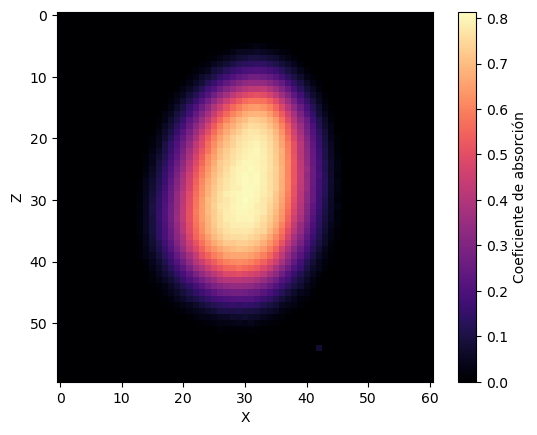

In [22]:
G = I/T
H = np.zeros(G.shape)
H = H+mean2
R = np.log(H/G)
R = np.where(R > 0, R, 0)
plt.imshow(R, cmap = color)
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Coeficiente de absorción')
plt.show()

## 5. Restauración (deconvolución)

Para realizar la restauración de los mapas hay que realizar una operación matemática llamada deconvolución, y es una operación entre el mapa de intensidad del haz incidente y el mapa de absorción. Para realizar esta operación matemática se emplearan dos métodos.
- Método de Weiner
- Método de Richarson-Lucy

### Método de Weiner.

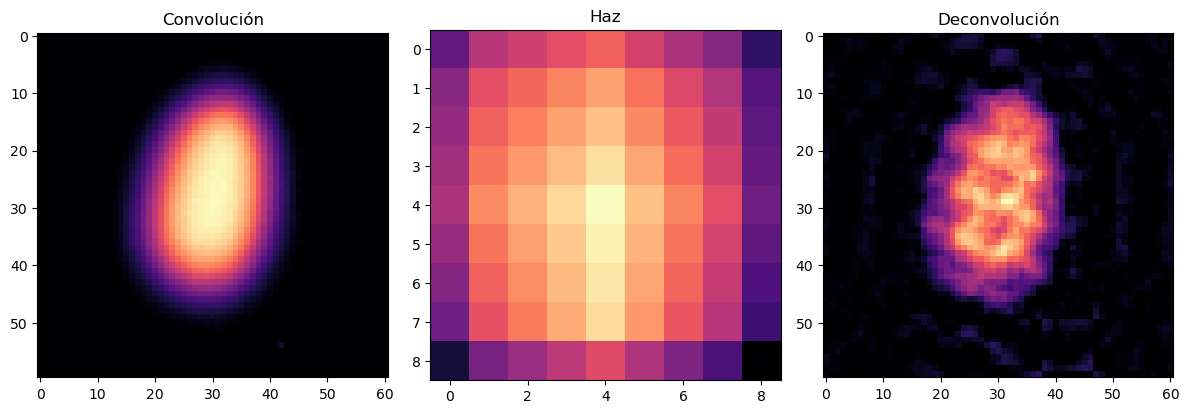

In [23]:
d, _ = unsupervised_wiener(R, h4)
d =  np.maximum(0,d)

fig, axes = plt.subplots(1, 3, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(R, cmap = color)
ax[0].set_title("Convolución")
ax[1].imshow(h4, cmap = color)
ax[1].set_title('Haz')
ax[2].imshow(d, cmap = color)
ax[2].set_title('Deconvolución')

fig.tight_layout()
plt.show()

### Metodo de Richarson-Lucy

In [24]:
#d1 = richardson_lucy(R, h4, iterations=10, clip = False)
#d2 = richardson_lucy(R, h4, iterations=20, clip = False)
#d3 = richardson_lucy(R, h4, iterations=40, clip = False)
#d4 = richardson_lucy(R, h4, iterations=80, clip = False)

#fig, axes = plt.subplots(2, 3, figsize=(12, 8))
#ax = axes.ravel()

#ax[0].imshow(R, cmap = color)
#ax[0].set_title("Convolución")
#ax[1].imshow(h4, cmap = color)
#ax[1].set_title('Haz')
#ax[2].imshow(d1, cmap = color)
#ax[2].set_title('Deconvolución-10')
#ax[3].imshow(d2, cmap = color)
#ax[3].set_title('Deconvolución-20')
#ax[4].imshow(d3, cmap = color)
#ax[4].set_title('Deconvolución-40')
#ax[5].imshow(d4, cmap = color)
#ax[5].set_title('Deconvolución-80')

#fig.tight_layout()
#plt.show()

In [25]:
#fig, axes = plt.subplots(1, 2, figsize=(12, 8))
#camera = Camera(fig)

#axes[0].set_title("Original")
#axes[1].set_title(f'Restaurado')

#for i in range(1, 101, 1):
#    axes[0].imshow(R, cmap = color)
#    img = richardson_lucy(R, h4, iterations=i, clip = False)
#    axes[1].imshow(img, cmap = color)
#    axes[1].text(10, 10, f'i = {i}', color='red', fontsize=12)
#    camera.snap()
#animation = camera.animate()

In [26]:
#animation.save('rest.gif', fps = 10)

![Descripción](rest.gif)

Visto que el método de Richarson-Lucy es el que proporciona una mejor restauración, aplicamos la transformación correspondiente con la ecuación $(I)$ para obtener la restauración del mapa de transmisión.

C:\Users\54112\AppData\Local\Temp\ipykernel_11984\4005108692.py:1: FutureWarning: `iterations` is a deprecated argument name for `richardson_lucy`. It will be removed in version 1.0. Please use `num_iter` instead.
  Td=H/np.exp(richardson_lucy(R, h4, iterations=40, clip = False))


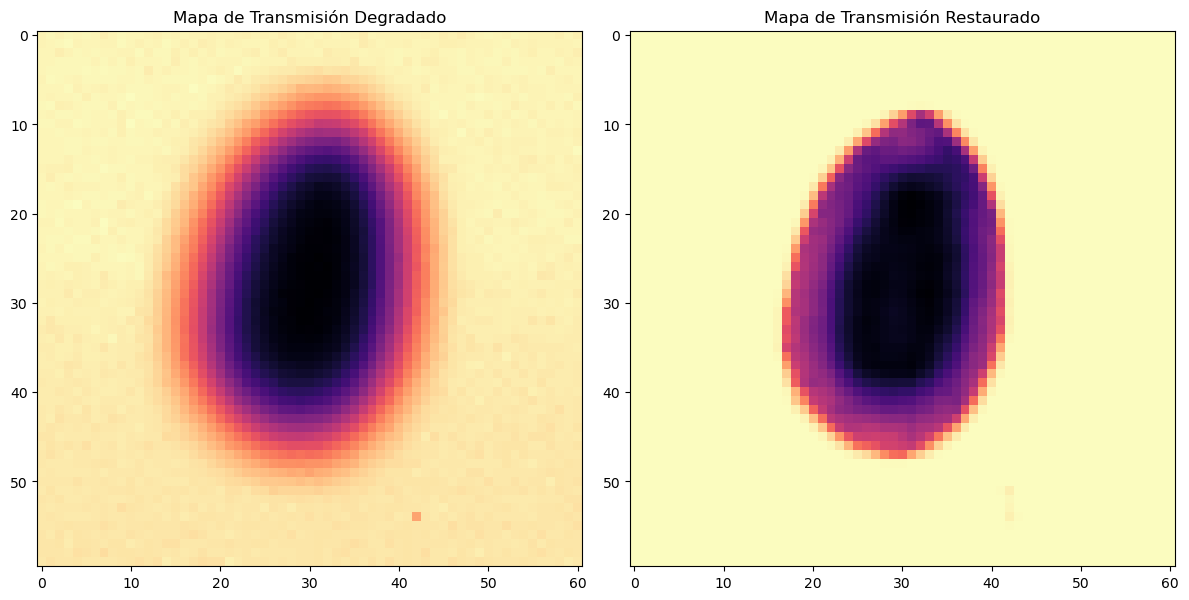

In [27]:
Td=H/np.exp(richardson_lucy(R, h4, iterations=40, clip = False))

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(G, cmap = color)
ax[0].set_title("Mapa de Transmisión Degradado")
ax[1].imshow(Td, cmap = color)
ax[1].set_title('Mapa de Transmisión Restaurado')

fig.tight_layout()
plt.show()

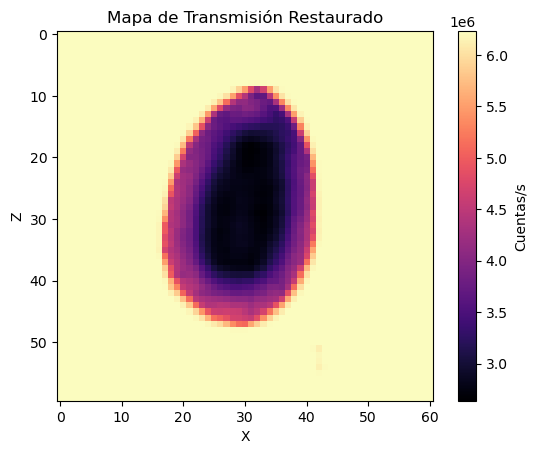

In [28]:
plt.imshow(Td, cmap = color)
plt.title('Mapa de Transmisión Restaurado')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas/s')
plt.show()

## 6. Resultados de la restauración

Se observa una disminución en el nivel de desenfoque en el mapa restaurado con respecto al degradado, esto se traduce en una reducción significativa y mejor definición de los bordes de la semilla. Otra característica importante a resaltar es el fondo del mapa (zona amarilla), ya que presenta una distribución de valores más homogénea, lo que da la percepción de un fondo más “limpio” o con menor nivel de ruido.

La restauración no afectó únicamente en el nivel de desenfoque y ruido del mapa, sino también en los valores de los pixeles. Para observar este cambio se puede graficar el perfil de intensidad transmitida del mapa degradado y resturado en la zona que corresponde al centro de la semilla.

C:\Users\54112\AppData\Local\Temp\ipykernel_11984\1086061375.py:1: FutureWarning: `iterations` is a deprecated argument name for `richardson_lucy`. It will be removed in version 1.0. Please use `num_iter` instead.
  d5 = richardson_lucy(R, h4, iterations=40, clip = False)


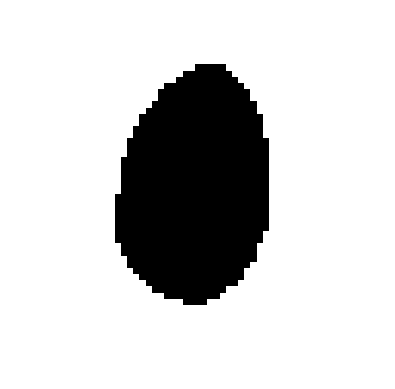

In [29]:
d5 = richardson_lucy(R, h4, iterations=40, clip = False)
d5 = np.where(d5<=0.1,0,d5)
d5 = np.where(d5==0,0,255)
d5= d5.astype(np.uint8)
d5[54:,0:10]=0
d5[54:,50:61]=0
d6 = np.where(d5==255,0,255)
plt.imshow(d6,cmap='gray')
plt.axis('off')
plt.savefig('ARL151')
plt.show()

In [30]:
x1,y1,w1,h5 = cv2.boundingRect(d5)
ruta= os.getcwd()
x1,y1,w1,h5

(17, 9, 25, 39)

In [31]:
b = Td[int((x1+w1+1)/2),y1:y1+h5]

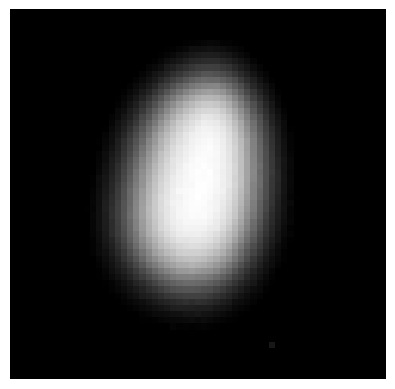

In [32]:
plt.imshow(R,cmap='gray')
plt.axis('off')
plt.savefig('ARL152')
plt.show()

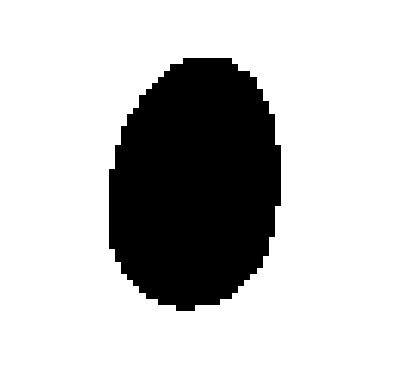

In [33]:
d7 = np.where(R<0.1,0,R)
d7 = np.where(d7==0,0,255)
d7= d7.astype(np.uint8)
d7[54:,0:10]=0
d7[54:,50:61]=0
d8 = np.where(d7==255,0,255)
plt.imshow(d8,cmap='gray')
plt.axis('off')
plt.savefig('ARL153')
plt.show()

In [34]:
x2,y2,w2,h6 = cv2.boundingRect(d7)
ruta= os.getcwd()
x2,y2,w2,h6

(16, 8, 28, 41)

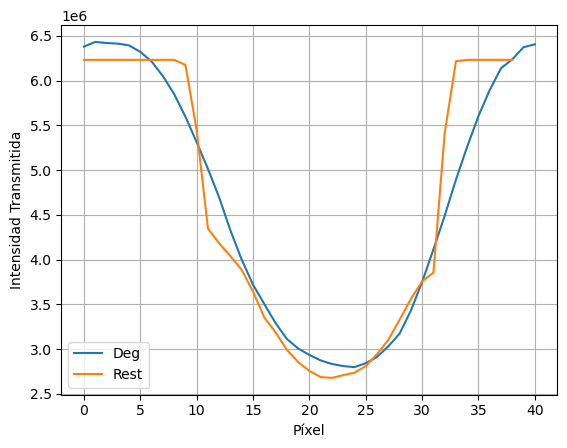

In [35]:
a = G[int((x2+w2+1)/2),y2:y2+h6]
plt.plot(a, label="Deg")
plt.plot(b, label  ="Rest")
plt.xlabel('Píxel')
plt.ylabel('Intensidad Transmitida')
plt.grid()
plt.legend()
plt.show()

se observa que la intensidad transmitida alcanza valores más bajos y cae de manera más pronunciada en el mapa restaurado, así mismo una mejor definición de los bordes de la semilla se traduce en una disminución en sus dimensiones. Si se
considera que la densidad electrónica y másica de la semilla es similar en todo su volumen, el perfil obtenido se puede asociar a la geometría de un elipsoide oblato.